In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict
from matplotlib.colors import LinearSegmentedColormap
from pyfaidx import Fasta
import allel

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## load samples

In [3]:
def load_groupfile(groupfile):
    group_ordered = []
    samples_queried = []
    haps_queried = []
    group2haps = defaultdict(list)
    hap2group = {}
    group2samples = defaultdict(list)
    with open(groupfile) as f:
        for line in f:
            sample, group = line.strip().split()
            if group not in group_ordered:
                group_ordered.append(group)  
            samples_queried.append(sample)
            group2samples[group].append(sample)
            # haps_queried.append(f'{sample}_1')
            # haps_queried.append(f'{sample}_2')
            group2haps[group].append(f'{sample}_1')
            group2haps[group].append(f'{sample}_2')
            hap2group[f'{sample}_1'] = group
            hap2group[f'{sample}_2'] = group
    return samples_queried, group_ordered, group2haps, hap2group, group2samples

In [4]:
groupfile = '500_sample2breed.tsv'

In [5]:
samples_queried, group_ordered, group2haps, hap2group, group2samples = load_groupfile(groupfile)

In [6]:
for group, ls in group2samples.items(): 
    print(group, len(ls))

Angus 100
Hereford 100
Charolais 100
Simmental 100
Limousin 100


## load vcf files

In [9]:
chrom = 6
start = 37349373
end = 37438248

In [10]:
vcffile='./Chr6_37180233_37768454_500_beef_samples_SNP-INDEL.vcf.gz'

In [11]:
callset = allel.read_vcf(
    vcffile, 
    region=f'{chrom}:{start}-{end}', 
    # samples=samples_queried, 
    fields=['samples', 'calldata/GT', 'variants/POS', 'variants/ALT', 'variants/REF'], 
    alt_number=1, #自动过滤掉多等位位点，仅保留二等位
    tabix='~/software/htslib-1.18/tabix'
)

## split genotype to haplotype

In [12]:
num_sites, num_inds, num_ploidy = callset['calldata/GT'].shape

In [13]:
ay_hap = np.empty((num_sites, num_inds * 2))

In [14]:
ay_hap[:, ::2] = callset['calldata/GT'][:, :, 0]
ay_hap[:, 1::2] = callset['calldata/GT'][:, :, 1]

## load haplotype array to dataframe

In [15]:
haps_queried = []
for sample in callset['samples']:
    haps_queried.extend([f'{sample}_1', f'{sample}_2'])

In [16]:
df_hap = pd.DataFrame(
    data=ay_hap, 
    index=callset['variants/POS'], 
    columns=haps_queried,
    dtype=int
)

## get haplotype A and D

In [18]:
ls_5_shared_snp = [37349373, 37362802, 37381106, 37381397, 37438248]

In [20]:
ls_all_0 = []
ls_all_1 = []

In [21]:
for hap in df_hap.columns:
    if df_hap.loc[ls_5_shared_snp,hap].sum() == 0:
        ls_all_0.append(hap)
    elif df_hap.loc[ls_5_shared_snp,hap].sum() == 5:
        ls_all_1.append(hap)

In [22]:
ls_all_0

['AANUSAM000004285114_1',
 'AANUSAM000004285114_2',
 'AANNZLM016932004379_1',
 'AANNZLM016932004379_2',
 'AANUSAMCSU20122222_1',
 'AANUSAMCSU20122222_2',
 'AANUSAMCSU20122385_1',
 'AANUSAMCSU20122385_2',
 'AANUSAMCSU20144019_1',
 'AANUSAMCSU20144019_2',
 'AANUSAMCSU20122162_1',
 'AANUSAMCSU20122162_2',
 'AANUSAM000013739532_1',
 'AANUSAM000013739532_2',
 'AANUSAMCSU20166307_1',
 'AANUSAMCSU20166307_2',
 'AANUSAMCSU20166246_1',
 'AANUSAMCSU20166246_2',
 'AANUSAMCSU20166095_1',
 'AANUSAMCSU20166095_2',
 'AANUSAMCSU20166024_1',
 'AANUSAMCSU20166024_2',
 'AANUSAMCSU20122108_1',
 'AANUSAMCSU20122108_2',
 'AANUSAM000005475692_1',
 'AANUSAM000005475692_2',
 'AANUSAM000015840414_1',
 'AANUSAM000015840414_2',
 'AANUSAM000014675445_1',
 'AANUSAM000014675445_2',
 'AANUSAM000013898124_1',
 'AANUSAM000013898124_2',
 'AANNZLM017683008844_1',
 'AANNZLM017683008844_2',
 'AANUSAM000013305978_1',
 'AANUSAM000013305978_2',
 'AANUSAM000012396224_1',
 'AANUSAM000012396224_2',
 'AANUSAM000014959541_1',
 'AA

In [23]:
breed = 'Charolais'

In [33]:
ls_breeds = ['Charolais', 'Simmental', 'Limousin', 'Hereford', 'Angus']

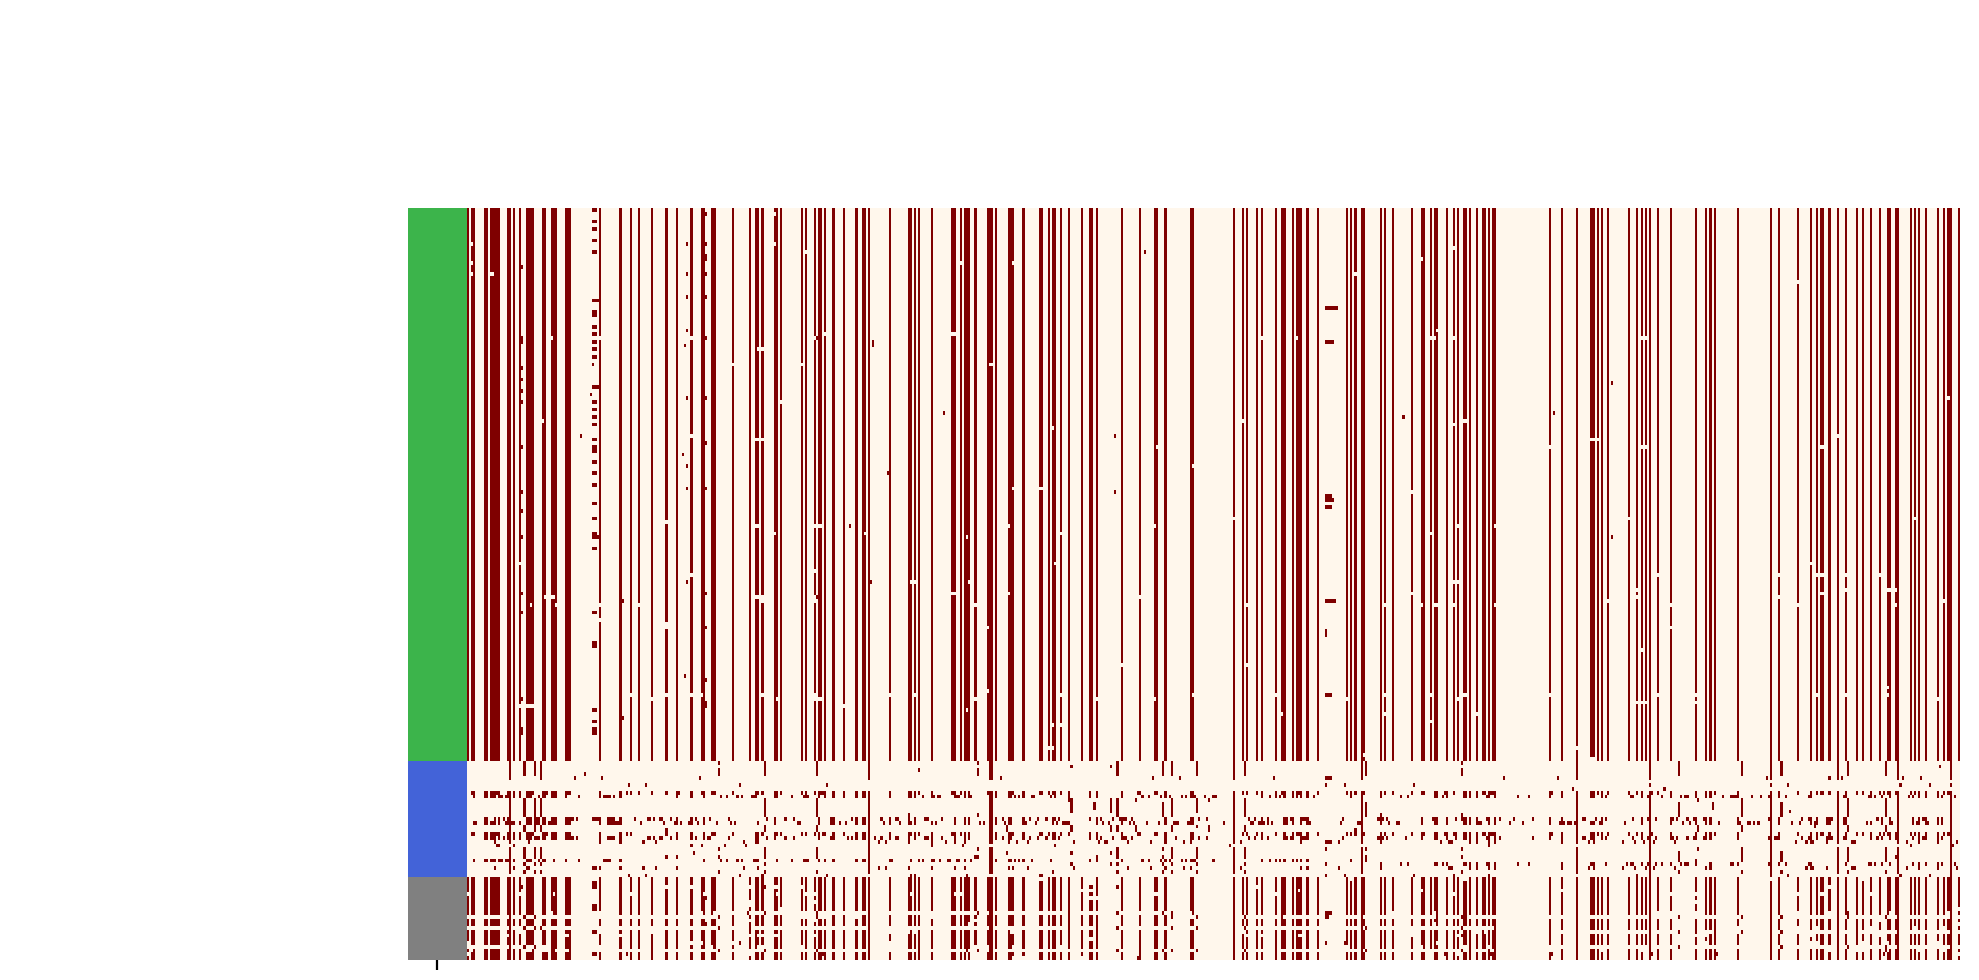

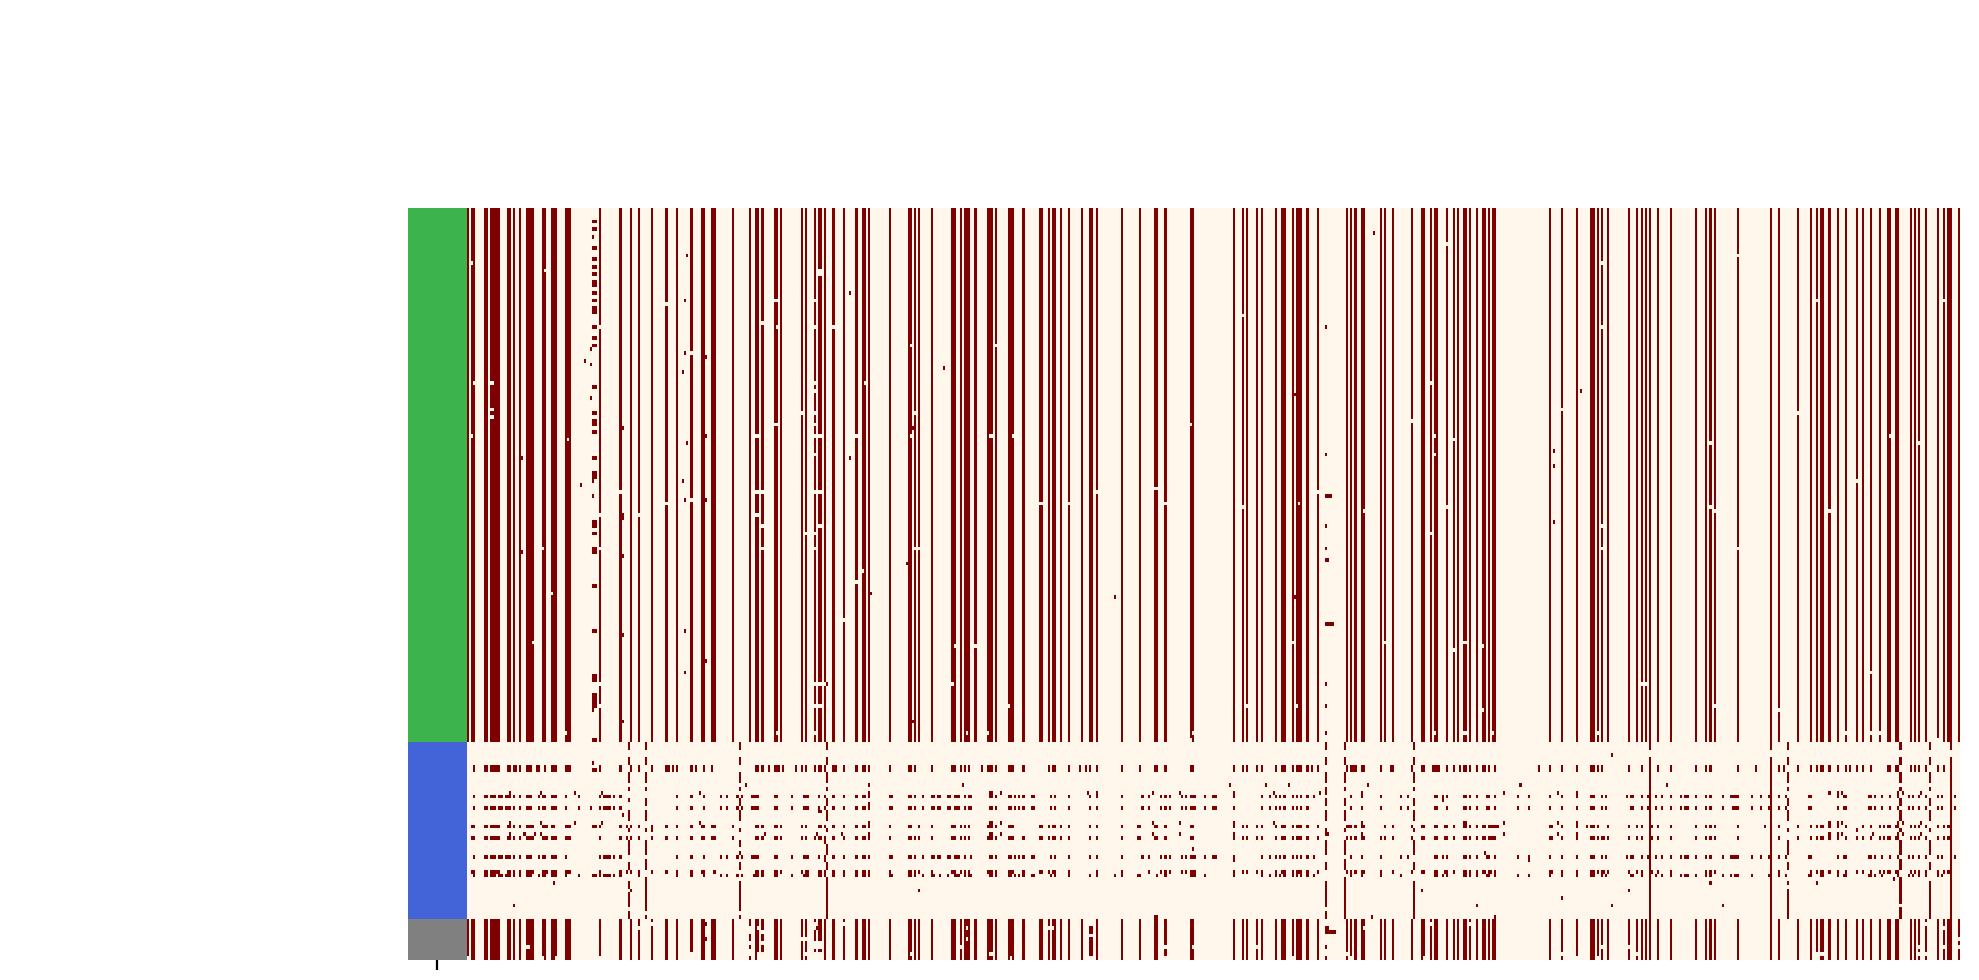

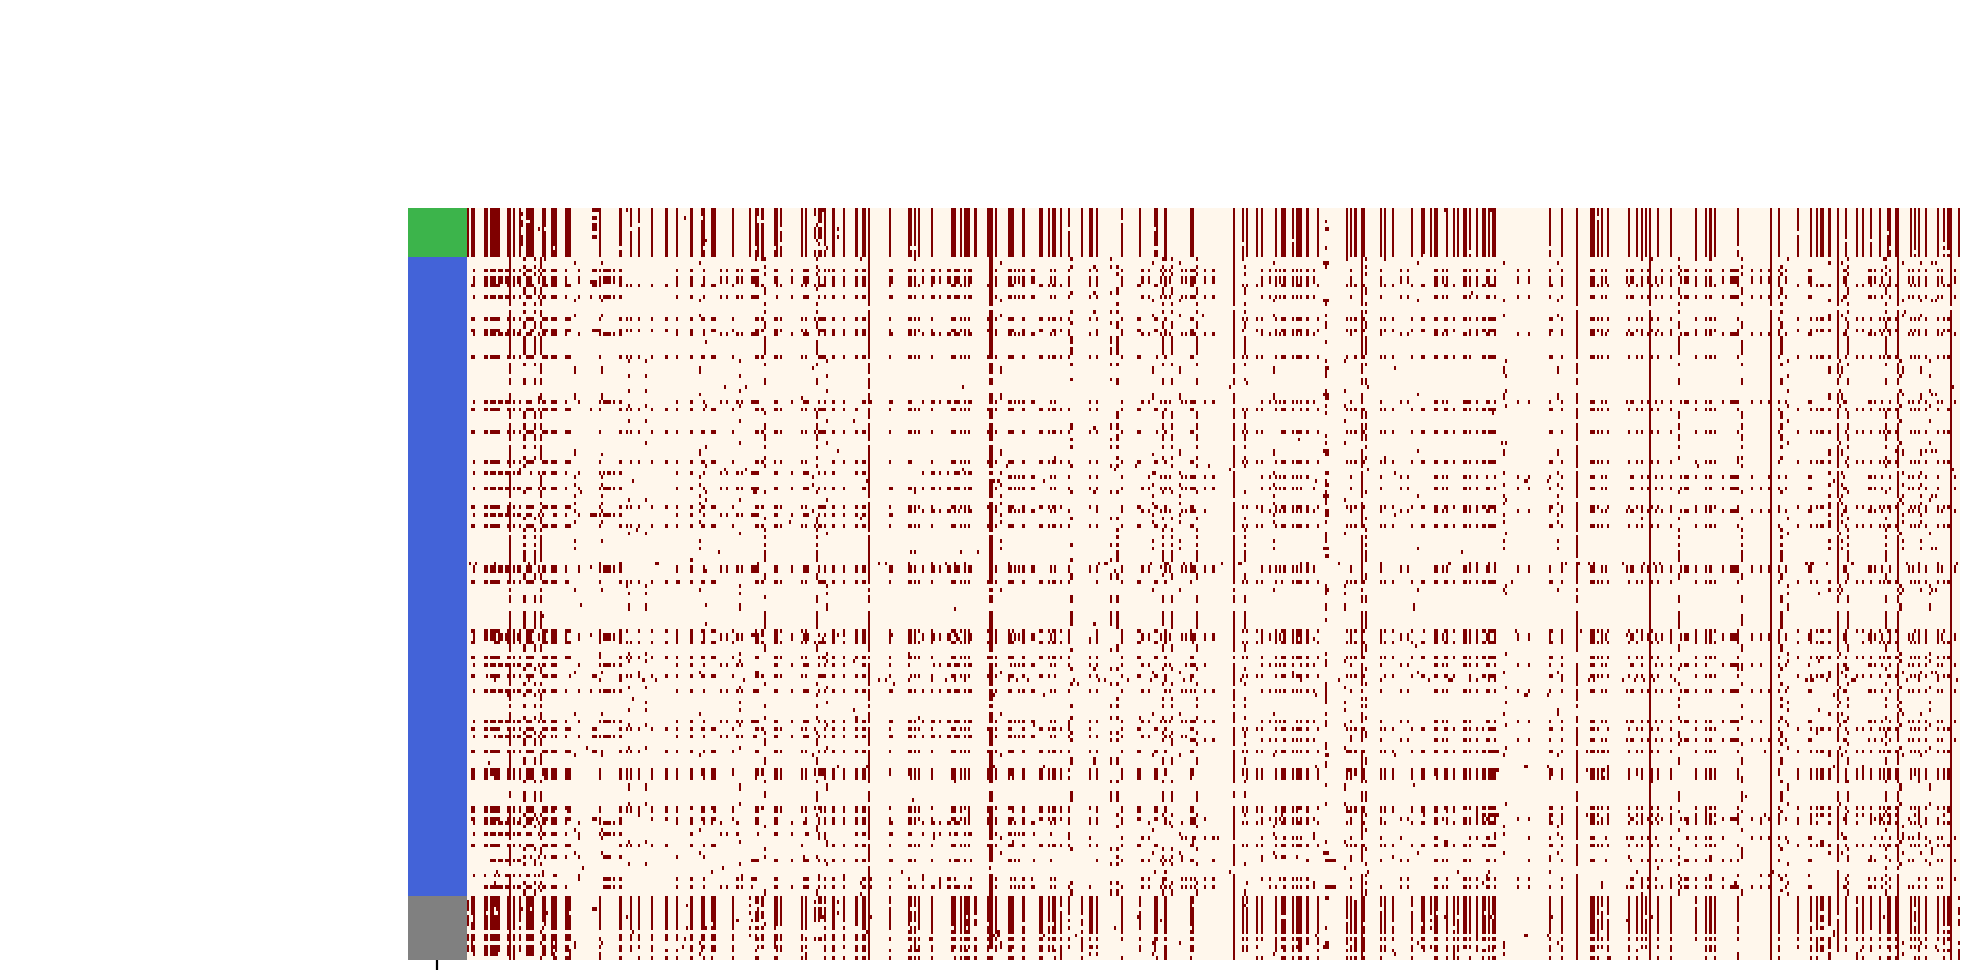

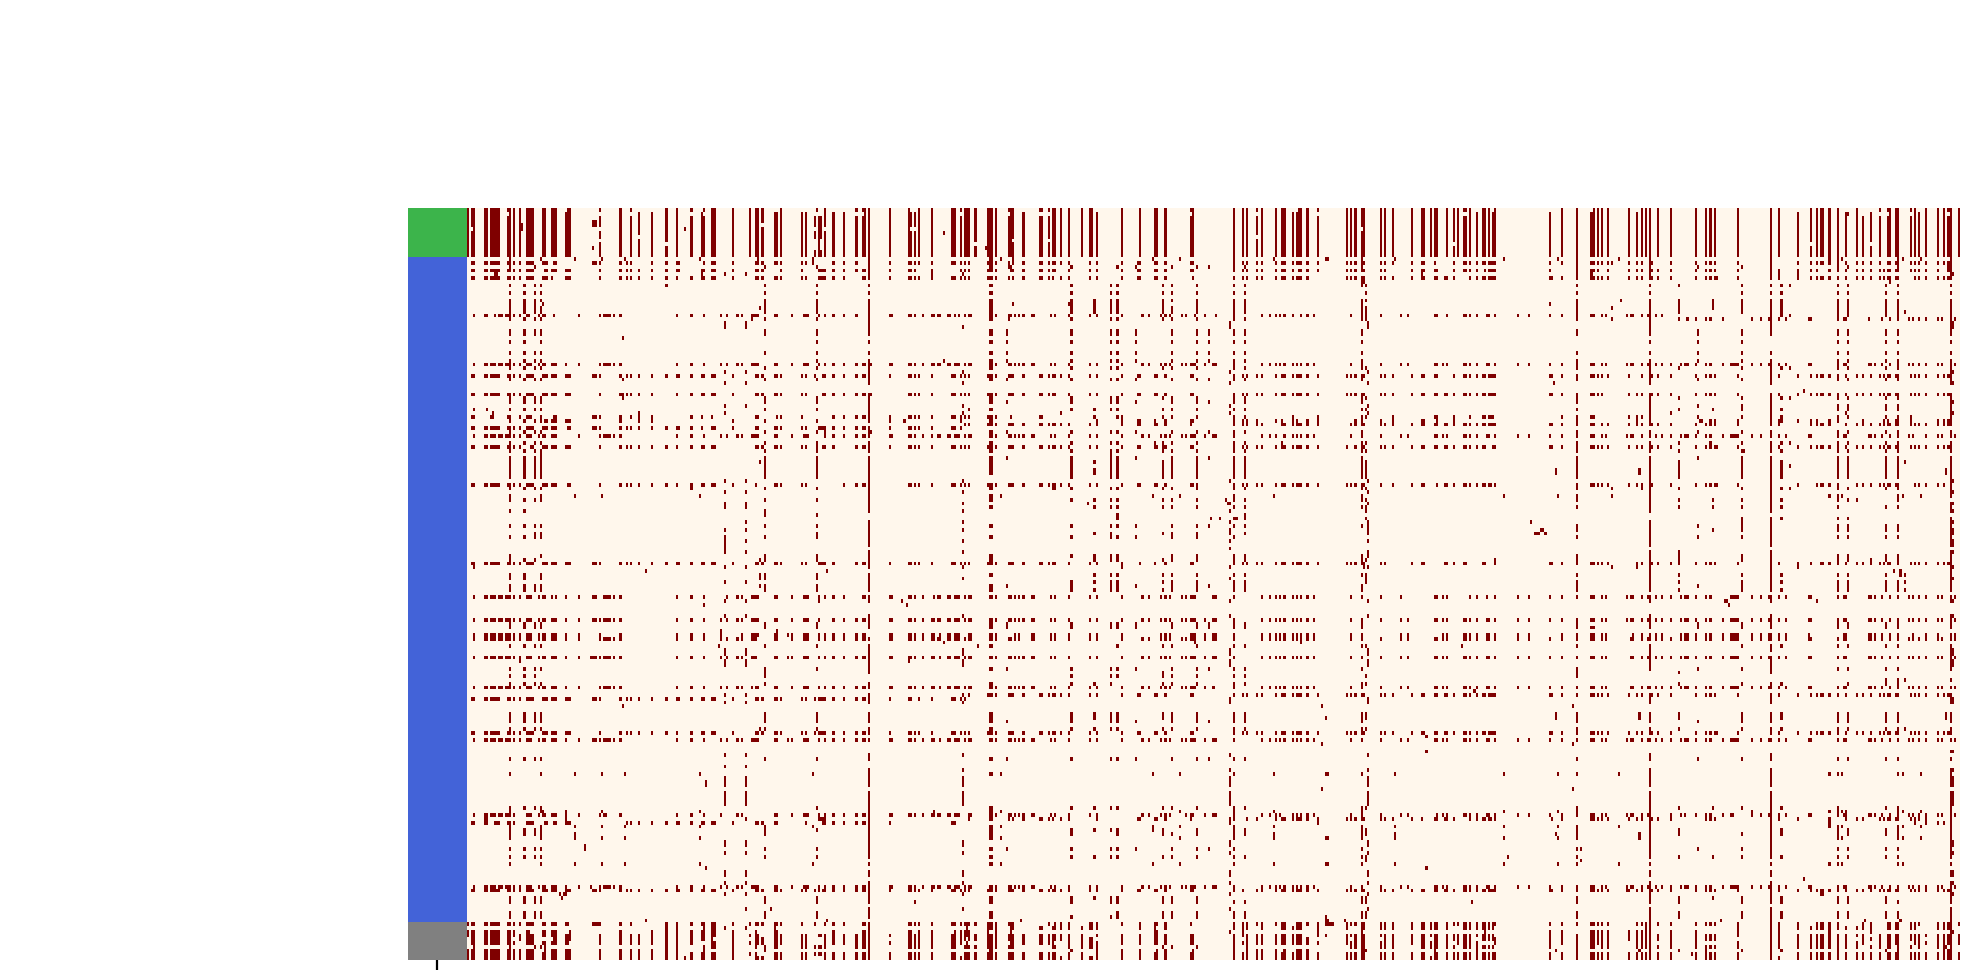

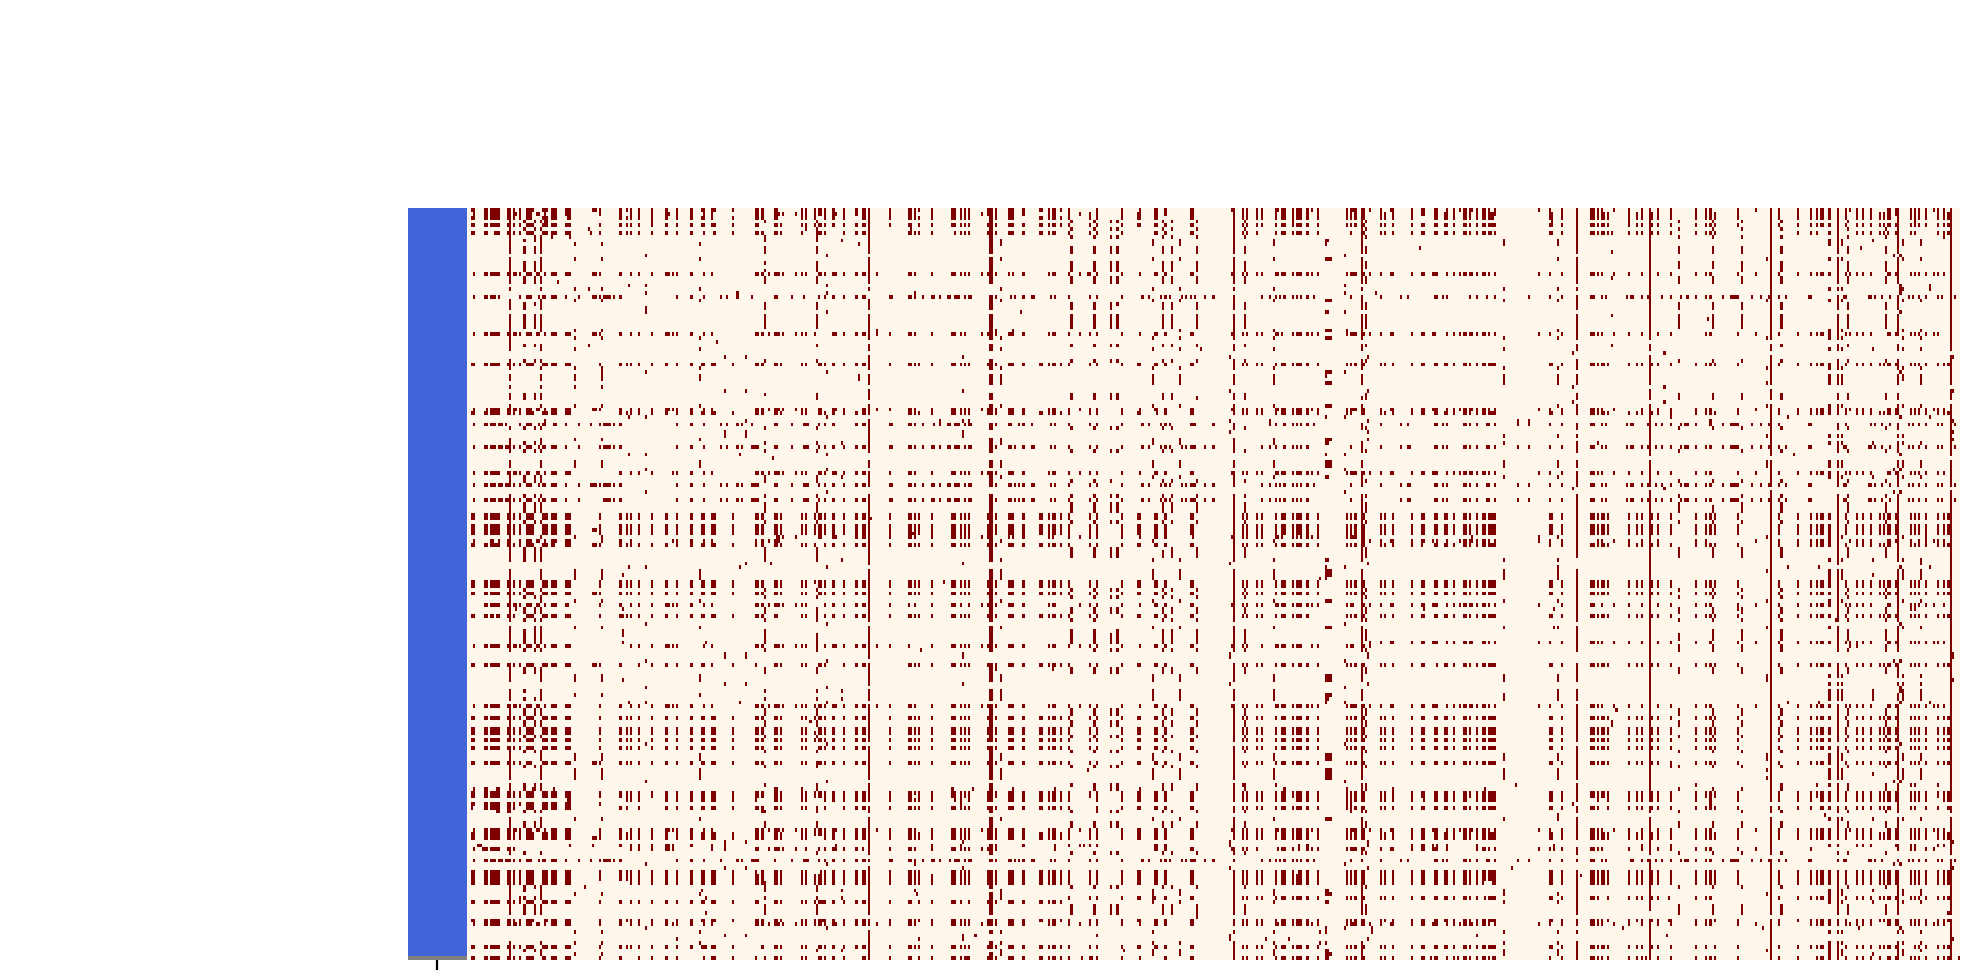

In [35]:
for breed in ls_breeds:
    ls_hap_sort = []
    hap2c = {}
    for hap in group2haps[breed]:
        if hap in ls_all_1:
            ls_hap_sort.append(hap)
            hap2c[hap] = '#3cb44b'

    for hap in group2haps[breed]:
        if hap in ls_all_0:
            ls_hap_sort.append(hap)
            hap2c[hap] = '#4363d8'

    for hap in group2haps[breed]:
        if (hap not in ls_all_0) and (hap not in ls_all_1):
            ls_hap_sort.append(hap)
            hap2c[hap] = 'grey'



    myColors = ((179/255, 179/255, 179/255, 1.0), (255/255, 247/255, 236/255, 1.0),  (127/255, 0, 0, 1.0))
    cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))
    
    g = sns.clustermap(
        df_hap.loc[:, ls_hap_sort].T, 
        row_cluster=False, 
        col_cluster=False, 
        yticklabels=False, 
        xticklabels=False, #添加选项，是否显示xtick
        cmap=cmap, 
        row_colors=pd.Series(hap2c),
        vmin=-1, 
        vmax=1, 
        cbar_pos=None,
        # cbar_kws={"ticks":[-0.7, 0, 0.7]}, 
        figsize=(10, 5)
    )

    plt.rcParams['pdf.use14corefonts'] = True
    g.savefig(f'LCORL_haplotype_all_0_1_{breed}.png', bbox_inches = 'tight', dpi=300)